In [1]:
import os
os.environ["PATH"] = "/home/jovyan/.mlspace/envs/flux-tune-iana/bin:" + os.environ["PATH"]
os.environ["CUDA_HOME"] = "/home/jovyan/shares/SR008.fs2/iana_kulichenko/cuda-12.4"
os.environ["PATH"] = os.path.join(os.environ["CUDA_HOME"], "bin") + ":" + os.environ["PATH"]
print("CUDA_HOME =", os.environ["CUDA_HOME"])
print("PATH =", os.environ["PATH"])
!nvcc --version

CUDA_HOME = /home/jovyan/shares/SR008.fs2/iana_kulichenko/cuda-12.4
PATH = /home/jovyan/shares/SR008.fs2/iana_kulichenko/cuda-12.4/bin:/home/jovyan/.mlspace/envs/flux-tune-iana/bin:/home/jovyan/.mlspace/envs/flux-tune-iana/bin:/home/user/conda/condabin:/home/user/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/user/conda/bin
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Tue_Feb_27_16:19:38_PST_2024
Cuda compilation tools, release 12.4, V12.4.99
Build cuda_12.4.r12.4/compiler.33961263_0


In [13]:
import os
import glob
import json
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
class_colors = {
    "TV stand":        "#FF0000",  # Red
    "bar counter":     "#0000FF",  # Blue
    "bench":           "#FFFF00",  # Yellow
    "bookshelf":       "#FFBFBF",  # Light Pink
    "cabinet":         "#00FF00",  # Green
    "chair":           "#FFA500",  # Orange
    "chair-bed":       "#40E0D0",  # Turquoise
    "coffee table":    "#272643",  # Dark Slate Blue
    "desk":            "#FFD9BF",  # Light Peach
    "dining table":    "#8B00FF",  # Violet
    "fireplace":       "#FF9400",  # Orange-ish
    "floor lamp":      "#5500FF",  # Purple
    "floor plant":     "#29922C",  # Green
    "floor vase":      "#FF6347",  # Tomato
    "kitchen island":  "#ADFF2F",  # Green Yellow
    "modular kitchen": "#FF7F50",  # Coral
    "ottoman":         "#AFCC43",  # Lime Green
    "rocking chair":   "#FF8C00",  # Dark Orange
    "rug":             "#BAE8E8",  # Light Blue
    "shelves":         "#C71585",  # Medium Violet Red
    "side table":      "#00BFFF",  # Deep Sky Blue
    "sideboard":       "#DA70D6",  # Orchid
    "sofa":            "#FF00FF",  # Magenta
    "stool":           "#DC143C",  # Crimson
    "wardrobe":        "#552743",  # Violet dark
    "armchair":        "#4A2714",  # Dark Brown,
    "window":          "#000000",  # Black
}

In [23]:
import os
import glob
import json
from PIL import Image

BASE_FOLDER = "/home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/furniture_detection_yolo/dataset_furn_100"
ROOM_SPACE_COEFF   = 1.15    
OBJECT_SIZES_COEFF = 0.9     
DEFAULT_ROOM_WIDTH_M = 5.0   

REFERENCE_SIZES = {
    "tv stand":           {"length": 1.2, "width": 0.4, "height": 0.5},
    "bar counter":        {"length": 2.0, "width": 0.6, "height": 1.1},
    "bench":              {"length": 1.2, "width": 0.4, "height": 0.5},
    "bookshelf":          {"length": 1.0, "width": 0.3, "height": 2.0},
    "cabinet":            {"length": 1.0, "width": 0.5, "height": 0.9},
    "chair":              {"length": 0.5, "width": 0.5, "height": 0.9},
    "chair-bed":          {"length": 1.8, "width": 0.8, "height": 0.8},
    "coffee table":       {"length": 1.0, "width": 0.6, "height": 0.45},
    "desk":               {"length": 1.2, "width": 0.6, "height": 0.75},
    "dining table":       {"length": 1.8, "width": 0.9, "height": 0.75},
    "fireplace":          {"length": 1.2, "width": 0.4, "height": 1.0},
    "floor lamp":         {"length": 0.4, "width": 0.4, "height": 1.6},
    "floor plant":        {"length": 0.5, "width": 0.5, "height": 0.8},
    "floor vase":         {"length": 0.3, "width": 0.3, "height": 0.7},
    "kitchen island":     {"length": 2.0, "width": 1.0, "height": 0.9},
    "modular kitchen":    {"length": 2.5, "width": 0.6, "height": 0.9},
    "ottoman":            {"length": 0.8, "width": 0.8, "height": 0.4},
    "rocking chair":      {"length": 1.0, "width": 0.6, "height": 1.0},
    "rug":                {"length": 2.0, "width": 1.5, "height": 0.02},
    "shelves":            {"length": 1.0, "width": 0.3, "height": 2.0},
    "side table":         {"length": 0.5, "width": 0.5, "height": 0.5},
    "sideboard":          {"length": 1.6, "width": 0.5, "height": 0.9},
    "sofa":               {"length": 2.3, "width": 1.0, "height": 0.8},
    "stool":              {"length": 0.4, "width": 0.4, "height": 0.45},
    "wardrobe":           {"length": 1.2, "width": 0.6, "height": 2.0},
    "armchair":           {"length": 0.9, "width": 0.8, "height": 1.0},
    "window":             {"length": 1.4, "width": 0.1, "height": 1.4}
}

## Conver pixel to meters in JSON

In [38]:
def normalize_label(label: str) -> str:
    """
    Strip the '_<number>' suffix and lowercase.
    """
    m = re.match(r"(.+?)_(\d+)$", label.strip().lower())
    return m.group(1) if m else label.strip().lower()

def get_bbox_size(coords: dict) -> tuple:
    """
    Return (width_px, height_px) from width/height or x1,x2,y1,y2.
    """
    w = coords.get("width")
    h = coords.get("height")
    if w is not None and h is not None:
        return float(w), float(h)
    x1, x2 = coords.get("x1"), coords.get("x2")
    y1, y2 = coords.get("y1"), coords.get("y2")
    if None not in (x1, x2, y1, y2):
        return abs(float(x2)-float(x1)), abs(float(y2)-float(y1))
    return 0.0, 0.0

def compute_meters_per_pixel(annotations: list, img_w: int, img_h: int) -> float:
    """
    Average meters-per-pixel from reference objects, 
    defaulting to DEFAULT_ROOM_WIDTH_M/img_w if none valid.
    """
    ratios = []
    unknown = set()
    for ann in annotations:
        raw = ann.get("label", "").strip()
        base = normalize_label(raw)
        if base not in REFERENCE_SIZES:
            unknown.add(base)
            continue
        w_px, h_px = get_bbox_size(ann.get("coordinates", {}))
        if max(w_px, h_px) <= 0:
            continue
        ref = REFERENCE_SIZES[base]
        ref_size = max(ref["length"], ref["width"])
        ratios.append(ref_size / max(w_px, h_px))

    if unknown:
        raise ValueError(f"Unknown reference labels: {unknown}")

    return sum(ratios)/len(ratios) if ratios else (DEFAULT_ROOM_WIDTH_M / img_w)

def process_scene(txt_path: str, img_path: str, room_space=1.0, object_scale=1.0) -> list:
    """
    Read annotations and image, return scene with real-world dims.
    """
    # load annotations
    with open(txt_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    annotations = data.get("annotations", [])

    # load image
    with Image.open(img_path) as img:
        img_w, img_h = img.size

    mpp = compute_meters_per_pixel(annotations, img_w, img_h)
    if mpp <= 0:
        raise RuntimeError("Invalid meters-per-pixel scale")

    # room dims
    room_w = img_w * mpp * room_space
    room_d = img_h * mpp * room_space
    room_h = 2.5

    scene = [{
        "room_dimensions": [
            round(room_w, 2), round(room_d, 2), round(room_h, 2)
        ]
    }]

    counts = {}
    for ann in annotations:
        raw = ann.get("label", "").strip()
        base = normalize_label(raw)
        coords = ann.get("coordinates", {})
        cx, cy = coords.get("x", 0.0), coords.get("y", 0.0)
        w_px, h_px = get_bbox_size(coords)

        counts[base] = counts.get(base, 0) + 1
        obj_id = f"{base}_{counts[base]}"

        # footprint
        length_m = w_px * mpp * object_scale
        width_m  = h_px * mpp * object_scale
        if length_m < width_m:
            length_m, width_m = width_m, length_m

        ref = REFERENCE_SIZES[base]
        height_m = ref["height"] * object_scale
        rotation = 0 if w_px >= h_px else 90

        scene.append({
            "new_object_id": obj_id,
            "size_in_meters": {
                "length": round(length_m, 2),
                "width":  round(width_m, 2),
                "height": round(height_m, 2)
            },
            "position": {
                "x": round(cx * mpp * room_space, 2),
                "y": round(cy * mpp * room_space, 2),
                "z": 0.0
            },
            "rotation_z": rotation
        })

    return scene

def draw_2d_scene(scene: list, out_path: str):
    """
    Draw a top-down plan of the room and objects, using the predefined class_colors.
    """
    room_w, room_d, _ = scene[0]["room_dimensions"]
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect("equal")
    margin = max(room_w, room_d) * 0.1
    ax.set_xlim(-margin, room_w + margin)
    ax.set_ylim(-margin, room_d + margin)
    ax.axis("off")

    # draw room border
    ax.add_patch(patches.Rectangle((0, 0), room_w, room_d,
                                   linewidth=2, edgecolor="black", facecolor="none"))

    for obj in scene[1:]:
        # extract the base label (without the trailing _n)
        lbl = obj["new_object_id"].rsplit("_", 1)[0].lower()
        sz  = obj["size_in_meters"]
        pos = obj["position"]
        ang = math.radians(obj["rotation_z"])
        length, width = sz["length"], sz["width"]

        # get edge and fill colors
        hex_color = class_colors.get(lbl, "#000000")
        edge_color = hex_color
        fill_color = mcolors.to_rgba(hex_color, alpha=0.3)

        # create and transform the rectangle
        rect = patches.Rectangle(
            (-length/2, -width/2), length, width,
            linewidth=1, edgecolor=edge_color, facecolor=fill_color
        )
        trans = transforms.Affine2D().rotate(ang).translate(pos["x"], pos["y"]) + ax.transData
        rect.set_transform(trans)
        ax.add_patch(rect)

        # label the object
        ax.text(
            pos["x"], pos["y"], lbl,
            ha="center", va="center", fontsize=8, color="black",
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
        )

    plt.savefig(out_path, bbox_inches="tight", pad_inches=0.1)
    plt.close(fig)
    print(f"Saved layout to {out_path}")

In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.transforms as transforms
from PIL import Image
import os
import glob
import json
import re
import math

In [40]:
BASE_FOLDER = "/home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/furniture_detection_yolo/dataset_furn_100"

In [41]:
# txt_files = glob.glob(os.path.join(BASE_FOLDER, "*_fixed.txt"))
# txt_files

In [42]:
txt_files = glob.glob(os.path.join(BASE_FOLDER, "*_fixed.txt"))

for txt_path in txt_files:
    scene_name = os.path.basename(txt_path).replace("_fixed.txt", "")
    img_path   = os.path.join(BASE_FOLDER, f"{scene_name}_img_fixed.jpg")

    if not os.path.exists(img_path):
        print(f"[WARN] No image for scene '{scene_name}' -> {img_path}")
        continue

    print(f"\nProcessing scene: {scene_name}")
    scene_data = process_scene(
        txt_path,
        img_path,
        room_space=ROOM_SPACE_COEFF,
        object_scale=OBJECT_SIZES_COEFF
    )

    # save JSON
    output_json = os.path.join(BASE_FOLDER, f"{scene_name}_3d.json")
    with open(output_json, "w", encoding="utf-8") as f:
        json.dump(scene_data, f, indent=2, ensure_ascii=False)
    print(f"[OK] JSON saved: {output_json}")

    # draw layout
    output_img = os.path.join(BASE_FOLDER, f"{scene_name}_meters_layout.jpg")
    draw_2d_scene(scene_data, output_img)
    print(f"[OK] Layout saved: {output_img}")


Processing scene: 100_jpg.rf.418df30a5e834bb29497aa8c90c06e33
[OK] JSON saved: /home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/furniture_detection_yolo/dataset_furn_100/100_jpg.rf.418df30a5e834bb29497aa8c90c06e33_3d.json
Saved layout to /home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/furniture_detection_yolo/dataset_furn_100/100_jpg.rf.418df30a5e834bb29497aa8c90c06e33_meters_layout.jpg
[OK] Layout saved: /home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/furniture_detection_yolo/dataset_furn_100/100_jpg.rf.418df30a5e834bb29497aa8c90c06e33_meters_layout.jpg

Processing scene: 101_jpg.rf.63fa4155791920cd75f8b68ec8530d71
[OK] JSON saved: /home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/furniture_detection_yolo/dataset_furn_100/101_jpg.rf.63fa4155791920cd75f8b68ec8530d71_3d.json
Saved layout to /home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/furniture_detection_yolo/dataset_furn_100/101_jpg.rf.63fa4155791920cd75f8b68ec8530d71_meters_layout.jpg

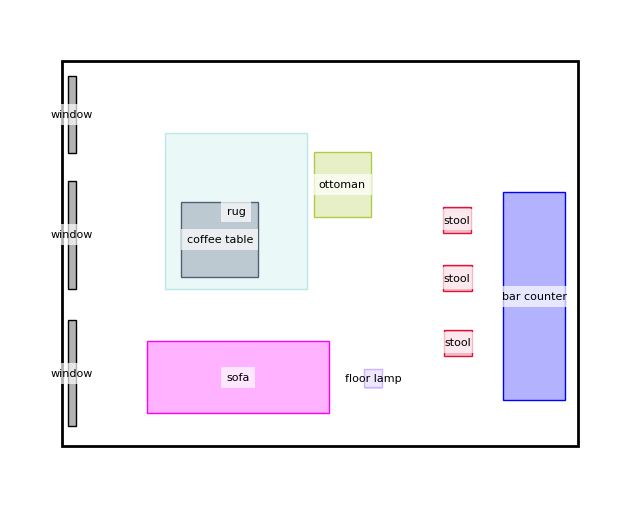

In [45]:
def draw_layout_from_json(json_path: str):
    with open(json_path, 'r', encoding='utf-8') as f:
        scene = json.load(f)

    room_w, room_d, _ = scene[0]["room_dimensions"]

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    margin = max(room_w, room_d) * 0.1
    ax.set_xlim(-margin, room_w + margin)
    ax.set_ylim(-margin, room_d + margin)
    ax.axis('off')

    ax.add_patch(patches.Rectangle((0, 0), room_w, room_d,
                                   linewidth=2, edgecolor='black', facecolor='none'))

    for obj in scene[1:]:
        lbl = obj["new_object_id"].rsplit("_", 1)[0].lower()
        sz  = obj["size_in_meters"]
        pos = obj["position"]
        ang = math.radians(obj["rotation_z"])
        length, width = sz["length"], sz["width"]

        hex_color = class_colors.get(lbl, "#000000")
        edge_color = hex_color
        fill_color = mcolors.to_rgba(hex_color, alpha=0.3)

        rect = patches.Rectangle(
            (-length/2, -width/2), length, width,
            linewidth=1, edgecolor=edge_color, facecolor=fill_color
        )
        transform = transforms.Affine2D().rotate(ang).translate(pos["x"], pos["y"]) + ax.transData
        rect.set_transform(transform)
        ax.add_patch(rect)

        ax.text(
            pos["x"], pos["y"], lbl,
            ha='center', va='center',
            fontsize=8, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )

    plt.show()

json_path = "/home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/dataset_sft/100_jpg.rf.418df30a5e834bb29497aa8c90c06e33_2d.json"
draw_layout_from_json(json_path)

In [86]:
# base_folder = "/home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/detection/dataset_furn_100"
# txt_files = glob.glob(os.path.join(base_folder, "*_fixed.txt"))
# ROOM_SPACE_COEFF = 1.15    
# OBJECT_SIZES_COEFF = 0.9  

# for txt_path in txt_files:
#     scene_name = os.path.basename(txt_path).replace("_fixed.txt", "")
#     img_path = os.path.join(base_folder, scene_name + "_img_fixed.jpg")

#     if not os.path.exists(img_path):
#         print(f"[WARN] Нет картинки для: {txt_path}")
#         continue

#     print(f"\nОбрабатываем сцену: {scene_name}")
#     # Задаём room_space и object_sizes
#     scene_data = process_scene(
#         txt_path, 
#         img_path, 
#         scene_name,
#         room_space=ROOM_SPACE_COEFF,
#         object_sizes=OBJECT_SIZES_COEFF
#     )

#     # Сохраняем JSON
#     output_path = os.path.join(base_folder, scene_name + "_3d.json")
#     with open(output_path, "w", encoding="utf-8") as out_f:
#         json.dump(scene_data, out_f, indent=2, ensure_ascii=False)
#     print(f"[OK] Итоговый JSON: {output_path}")

#     # Рисуем 2D-сцену
#     out_image_2d = os.path.join(base_folder, scene_name + "_meters_layout.jpg")
#     draw_2d_scene(scene_data, out_image_2d)


Обрабатываем сцену: 100_jpg.rf.418df30a5e834bb29497aa8c90c06e33
[OK] Итоговый JSON: /home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/detection/dataset_furn_100/100_jpg.rf.418df30a5e834bb29497aa8c90c06e33_3d.json
Scene saved to: /home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/detection/dataset_furn_100/100_jpg.rf.418df30a5e834bb29497aa8c90c06e33_meters_layout.jpg

Обрабатываем сцену: 101_jpg.rf.63fa4155791920cd75f8b68ec8530d71
[OK] Итоговый JSON: /home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/detection/dataset_furn_100/101_jpg.rf.63fa4155791920cd75f8b68ec8530d71_3d.json
Scene saved to: /home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/detection/dataset_furn_100/101_jpg.rf.63fa4155791920cd75f8b68ec8530d71_meters_layout.jpg

Обрабатываем сцену: 102_jpg.rf.aee3ccd56a3831ee88ccf8adb821311b
[OK] Итоговый JSON: /home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/detection/dataset_furn_100/102_jpg.rf.aee3ccd56a3831ee88ccf8adb821311b_3d.json
Scene sa

# Add style, materials, colors  with GigaChat-Max-preview

In [17]:
import requests
import uuid
import base64
import warnings
from requests.packages.urllib3.exceptions import InsecureRequestWarning
import json
from jsonschema import validate, ValidationError
import re
import os
import torch
import ssl

In [18]:
warnings.simplefilter('ignore', InsecureRequestWarning)

client_id = "..."
client_secret = "..."
authorization_key = "..."

oauth_url = "https://ngw.devices.sberbank.ru:9443/api/v2/oauth"

# generate a unique RqUID for the request
rq_uid = str(uuid.uuid4())

payload = {
    'scope': 'GIGACHAT_API_CORP',
    'grant_type': 'client_credentials'
}
headers = {
    'Content-Type': 'application/x-www-form-urlencoded',
    'Accept': 'application/json',
    'RqUID': rq_uid,
    'Authorization': f'Basic {authorization_key}'
}

# request to obtain the access token
response = requests.post(oauth_url, headers=headers, data=payload, verify=False)

if response.status_code == 200:
    access_token = response.json().get("access_token")
    print("Access token:", access_token)
else:
    print(f"Failed to obtain access token: {response.status_code}")
    print("Response:", response.text)

Access token: eyJjdHkiOiJqd3QiLCJlbmMiOiJBMjU2Q0JDLUhTNTEyIiwiYWxnIjoiUlNBLU9BRVAtMjU2In0.avubtxR-gXErE1ewxocQxf0ap0-DghnKdCfBnVvDDqdN15nw3ZWE8gRcmTBXttruX8gAFErxEyOI3qsWnE5zIFlHRC2ZqI1kASFR6qF3WPJla8NNymAJa_0q683mxPkFuQ_-qsxXKR44zqpDfb6cZdEFochmRLsnWLjLOXMvjYp8Sgq1KiI16Vha5t_awAJS5B4berTGYCSMpmBY-4LTv-jdhT86j33E9p4tawd6_YPXYg7vOXIy6fEnXZEbS4huoTYKf7i0WPm-OfGGFeAp2diLYIfOyhKXzINORQSJ-cCxRSDYaZvFtTN4z8hau1SFmxAWmjTHLJitiQYJuzjN2g.TROGOKyOsZeOP2XIIVI8sg.3-YJYkm8rsG-GmOQF0GUGFo99owHy75ZU9GCOV6aiPe25h_B3C1tExsmJ8LdH7Z5oDUmLupTlbX1j_0LRFJ6aNbayHZEs1a8BvZrMKxjS-mp0mr46oRdNdgP9ivBCeDXSE5F185JBp4iMxdLlOUsGqIdFhnXxOFuTTsUsvIZX1ouWjptxwB7eGt2htLoBNQpP_tgxt_mEbEO1v-VGMSrz5C6tIoYWvJHprkKVn7UIh-7Kep6h_4s02uXBL8LVSFovYhzcO1W-GGWNEqT1IU8zxVPGITDx3TJWDGv00xwBAK8sdIg9BV3jW38UIYp9jPruKUitJbkwl_rphwUsJQl8_r3JtBRE0uH7MuDPlnHZiSWcG7x6-m9PrkcQDSPIDgkdD-we3l7bbiPHGOq1Rk80vI5FeXoK6JHFSbyH_uPPloA-0D2cZb1yztlnP9zTzCiG0wWNbcUtLbmGAqvSvK1noJxzMM5LIYMbCZVYJLNVdqUKav81gI0mVvNFqoTNleKDZ-jDvz7ok2e8VtxHmuFDzcIckLFbW1z

In [19]:
access_token

'eyJjdHkiOiJqd3QiLCJlbmMiOiJBMjU2Q0JDLUhTNTEyIiwiYWxnIjoiUlNBLU9BRVAtMjU2In0.avubtxR-gXErE1ewxocQxf0ap0-DghnKdCfBnVvDDqdN15nw3ZWE8gRcmTBXttruX8gAFErxEyOI3qsWnE5zIFlHRC2ZqI1kASFR6qF3WPJla8NNymAJa_0q683mxPkFuQ_-qsxXKR44zqpDfb6cZdEFochmRLsnWLjLOXMvjYp8Sgq1KiI16Vha5t_awAJS5B4berTGYCSMpmBY-4LTv-jdhT86j33E9p4tawd6_YPXYg7vOXIy6fEnXZEbS4huoTYKf7i0WPm-OfGGFeAp2diLYIfOyhKXzINORQSJ-cCxRSDYaZvFtTN4z8hau1SFmxAWmjTHLJitiQYJuzjN2g.TROGOKyOsZeOP2XIIVI8sg.3-YJYkm8rsG-GmOQF0GUGFo99owHy75ZU9GCOV6aiPe25h_B3C1tExsmJ8LdH7Z5oDUmLupTlbX1j_0LRFJ6aNbayHZEs1a8BvZrMKxjS-mp0mr46oRdNdgP9ivBCeDXSE5F185JBp4iMxdLlOUsGqIdFhnXxOFuTTsUsvIZX1ouWjptxwB7eGt2htLoBNQpP_tgxt_mEbEO1v-VGMSrz5C6tIoYWvJHprkKVn7UIh-7Kep6h_4s02uXBL8LVSFovYhzcO1W-GGWNEqT1IU8zxVPGITDx3TJWDGv00xwBAK8sdIg9BV3jW38UIYp9jPruKUitJbkwl_rphwUsJQl8_r3JtBRE0uH7MuDPlnHZiSWcG7x6-m9PrkcQDSPIDgkdD-we3l7bbiPHGOq1Rk80vI5FeXoK6JHFSbyH_uPPloA-0D2cZb1yztlnP9zTzCiG0wWNbcUtLbmGAqvSvK1noJxzMM5LIYMbCZVYJLNVdqUKav81gI0mVvNFqoTNleKDZ-jDvz7ok2e8VtxHmuFDzcIckLFbW1zYfp2mK6fJCnm6

In [20]:
import os
import glob
import json
import requests
import ssl
import random

def gigachat_request(
    user_input,
    access_token,
    model="GigaChat-Max-preview",
    temperature=0.8,
    max_tokens=256
):
    token_clean = access_token.encode("ascii", "ignore").decode("ascii")

    chat_url = "https://gigachat-preview.devices.sberbank.ru/api/v1/chat/completions"
    headers = {
        "User-Agent": "python-requests/2.31.0",
        "Content-Type": "application/json; charset=UTF-8",
        "Accept": "application/json; charset=UTF-8",
        "Authorization": f"Bearer {token_clean}"
    }

    payload = {
        "model": model,
        "messages": [
            {
                "role": "system",
                "content": (
                    "You are an interior designer. Your task is to suggest materials and colors for room furniture. "
                    "Please return a concise answer with no extra text."
                )
            },
            {
                "role": "user",
                "content": user_input
            }
        ],
        "temperature": temperature,
        "max_tokens": max_tokens,
        "function_call": "auto",
        "stream": False,
        "update_interval": 0
    }

    ssl._create_default_https_context = ssl._create_unverified_context

    response = requests.post(
        chat_url,
        headers=headers,
        json=payload,
        verify=False
    )
    response.raise_for_status()
    data = response.json()
    text = data.get("choices", [{}])[0].get("message", {}).get("content", "")
    return text.strip()


def get_style_material_color_for_object(obj_data, common_room_style, access_token):
    object_id = obj_data["new_object_id"]
    length_m = obj_data["size_in_meters"]["length"]
    width_m = obj_data["size_in_meters"]["width"]

    palette_hint = random.choice([
        "light and airy tones",
        "warm and cozy shades",
        "neutral minimalist palette",
        "earthy and natural colors",
        "bold accent colors with modern contrast",
        "cool tones like blues and soft greys"
    ])

    user_input = f"""
    You are helping design a modern living room.

    There is an object with the following details:
    - ID: {object_id}
    - Dimensions: {length_m}m (L) x {width_m}m (W)

    Suggest a combination of:
    - Style (modern)
    - Material (e.g., fabric, leather, glass, wood)
    - Color (based on {palette_hint})

    Keep your answer concise and return it in this format:
    <style>, <material>, <color>
    """.strip()

    response_text = gigachat_request(user_input, access_token)
    parts = [p.strip() for p in response_text.split(",")]
    if len(parts) == 3:
        style_val, material_val, color_val = parts
    else:
        style_val = "modern"
        material_val = "fabric"
        color_val = "gray"

    return style_val, material_val, color_val


def update_scene_with_llm(scene_data, common_room_style, access_token):
    style_cache = {}

    for element in scene_data:
        if "room_dimensions" in element:
            continue

        object_id = element.get("new_object_id", "")
        object_type = object_id.split("_")[0].lower()

        if object_type in style_cache:
            style_val, material_val, color_val = style_cache[object_type]
        else:
            style_val, material_val, color_val = get_style_material_color_for_object(
                element,
                common_room_style,
                access_token
            )
            style_cache[object_type] = (style_val, material_val, color_val)

        element["style"] = style_val
        element["material"] = material_val
        element["color"] = color_val

    return scene_data


base_folder = "/home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/detection/dataset_furn_100"
json_files = glob.glob(os.path.join(base_folder, "*_3d.json"))

COMMON_ROOM_STYLE = "modern"
ACCESS_TOKEN = access_token  

for json_path in json_files:
    print(f"\nProcessing file: {json_path}")
    try:
        with open(json_path, "r", encoding="utf-8") as f:
            content = f.read().strip()
            if not content:
                raise ValueError("Empty file.")
            scene_data = json.loads(content)

        updated_scene = update_scene_with_llm(scene_data, COMMON_ROOM_STYLE, ACCESS_TOKEN)

        with open(json_path, "w", encoding="utf-8") as f_out:
            json.dump(updated_scene, f_out, indent=2, ensure_ascii=False)

        print(f"[OK] Updated JSON saved: {json_path}")

    except (json.JSONDecodeError, ValueError) as e:
        print(f"[SKIPPED] Invalid or empty JSON: {json_path} — {str(e)}")
    except Exception as e:
        print(f"[ERROR] Failed to process {json_path} — {str(e)}")


Processing file: /home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/detection/dataset_furn_100/100_jpg.rf.418df30a5e834bb29497aa8c90c06e33_3d.json
[OK] Updated JSON saved: /home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/detection/dataset_furn_100/100_jpg.rf.418df30a5e834bb29497aa8c90c06e33_3d.json

Processing file: /home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/detection/dataset_furn_100/101_jpg.rf.63fa4155791920cd75f8b68ec8530d71_3d.json
[OK] Updated JSON saved: /home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/detection/dataset_furn_100/101_jpg.rf.63fa4155791920cd75f8b68ec8530d71_3d.json

Processing file: /home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/detection/dataset_furn_100/102_jpg.rf.aee3ccd56a3831ee88ccf8adb821311b_3d.json
[OK] Updated JSON saved: /home/jovyan/shares/SR008.fs2/iana_kulichenko/Experiments/detection/dataset_furn_100/102_jpg.rf.aee3ccd56a3831ee88ccf8adb821311b_3d.json

Processing file: /home/jovyan/shares/SR008.fs2/i